# NLOS with mitransient

## Overview

In this tutorial, you will simulate a NLOS capture setup with ``mitransient`` and its custom NLOS capabilities.

### Importing mitransient

In [1]:
import sys

# Import mitsuba and set the variant
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
import mitsuba as mi
mi.set_variant('llvm_ad_rgb')

import drjit as dr

# Import the mitransient extension that
# adds extra transient functionality to existing Mitsuba classes
sys.path.insert(1, '../..')
# We use the short alias mitr for mitransient to improve code readibility
import mitransient as mitr

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


### Setup the NLOS scene

In this tutorial you will learn how to prepare a NLOS scene using our library. We will do it following a programmatically way defining each component independently (note that a conversion directly from an XML like "nlos_Z.xml" is easy to do).

In [2]:
# Load the geometry of the hidden scene
geometry = mi.load_dict(
    {
        "type": "obj",
        "filename": "./Z.obj",
        "to_world": mi.ScalarTransform4f.translate([0.0, 0.0, 1.0]),
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
    }
)

# Load the emitter (laser) of the scene
emitter = mi.load_dict(
    {
        "type": "projector",
        "irradiance": 100.0,
        "fov": 0.2,
        "to_world": mi.ScalarTransform4f.translate([-0.5, 0.0, 0.25]),
    }
)

# Define the transient film which store all the data
transient_film = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "use_spad": True,
        "spad_csv": "../../20um_cmos.csv",
        "mod_spad": 1,
        "spad_volt": 5,
        "spad_lost": 0.3,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 5000},
        "account_first_and_last_bounces": False,
        "sensor_origin": [-0.5, 0.0, 0.25],
        "transient_film": transient_film,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
        "nlos_sensor": nlos_sensor,
    }
)

# Finally load the integrator
integrator = mi.load_dict(
    {
        "type": "transient_nlos_path",
        "nlos_laser_sampling": True,
        "nlos_hidden_geometry_sampling": True,
        "nlos_hidden_geometry_sampling_do_rroulette": False,
        "temporal_filter": "box",
    }
)

In [3]:
# Assemble the final scene
scene = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall,
    'integrator' : integrator
})

In [4]:
# Now we focus the emitter to irradiate one specific pixel of the "relay wall"
pixel = mi.Point2f(32, 32)
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall, emitter)

### Setup the `NLOS transient` integrator

In [5]:
# Prepare transient integrator for transient path tracing
# Does the work to initialize the scene before path tracing
transient_integrator = scene.integrator()
transient_integrator.prepare_transient(scene, sensor=0)
# sensor=0 just tells it to use the first sensor in the scene
# (in case there is more than one sensor in the XML file)

### Render the scene in steady and transient domain

In [6]:
# Render the scene and develop the data
data_steady, data_transient = transient_integrator.render(scene)
# And evaluate the output to launch the corresponding kernel
dr.eval(data_steady, data_transient)

### Visualize the steady and transient image

In [7]:
'''
You cannot see much in data_steady because it's the sum over
the temporal domain for the data captured at the relay wall
so there is no temporal information.
The temporal information is what allows you
to see around corners easier :)
'''
mi.util.convert_to_bitmap(data_steady)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [8]:
'''
data_transient is a 4D array represented as a Dr.JIT's TensorXf class.
It is very similar to a numpy array (in fact, you can convert between
the two by using np.array(data_transient))
'''
print(data_transient.__class__.__name__)
# The channels represent (x, y, time, rgb)
print(data_transient.shape)

TensorXf
(64, 64, 300, 3)


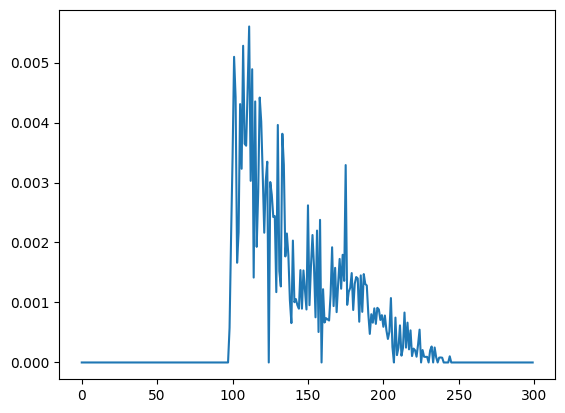

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# There are two main ways of plotting data_transient
# The first one is to plot a single pixel's time-resolved response
plt.plot(np.array(data_transient)[0, 0, :, 0])

(-0.5, 63.5, 63.5, -0.5)

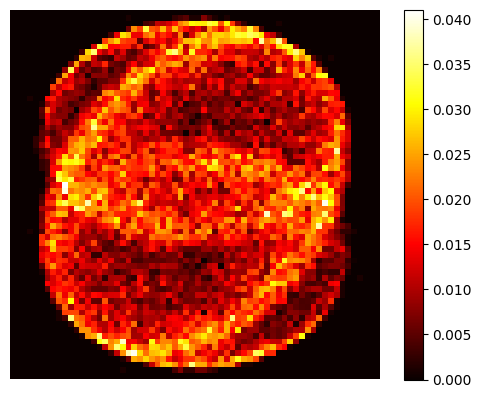

In [10]:
# The second one is to plot a frame of the transient video
# To understand this image, you can look at the paper:
# Non-Line-of-Sight Transient Rendering, Figure 4
plt.imshow(np.fliplr(np.array(data_transient)[:, :, 60, 0].T), cmap='hot')
plt.colorbar()
plt.axis('off')

### ADD `Crosstalk` to the steady image

In [61]:
from scipy import stats

def kernel_binomial(kernel_size, samples, CTP):
    
    kernel = stats.binom.rvs(samples, CTP, size=(kernel_size, kernel_size)) / samples
    kernel[kernel_size // 2, kernel_size // 2] = 0
    
    return kernel

def crosstalk(vector: np.ndarray, kernel_size, samples, CTP):
    if kernel_size == 1:
        return vector
    result = np.copy(vector)

    half_k = kernel_size // 2
    
    for i in range(half_k, vector.shape[0] - half_k):
        for j in range(half_k, vector.shape[1] - half_k):
            
            kernel = kernel_binomial(kernel_size, samples, CTP)
            
            region = vector[i-half_k:i+half_k+1, j-half_k:j+half_k+1]
            
            conv_value = np.sum(region * kernel)
            
            result[i, j] = vector[i, j] - (vector[i, j] * np.sum(kernel)) + conv_value
    
    return result

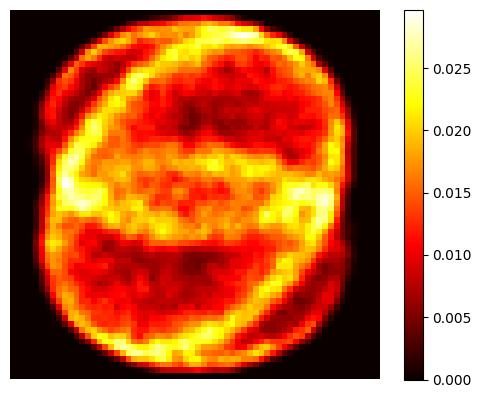

In [64]:
# The second one is to plot a frame of the transient video
# To understand this image, you can look at the paper:
# Non-Line-of-Sight Transient Rendering, Figure 4
data_CrossTalk = crosstalk(np.array(data_transient)[:, :, 60, 0].T, 3, scene.sensors()[0].sampler().sample_count(), 0.1)
plt.imshow(np.fliplr(data_CrossTalk), cmap='hot')
plt.colorbar()
plt.axis('off')
plt.show()

In [13]:
# Mitsuba transient offers a utility function to show videos
# although it is mostly unused in NLOS simulations

mitr.utils.show_video(np.moveaxis(data_transient, 0, 1), 2, uint8_srgb=True)